In [77]:
%matplotlib inline

from Basilisk.utilities import (
    SimulationBaseClass,
    macros,
    unitTestSupport,
    vizSupport
)

from Basilisk.simulation import (
    spacecraft,
    extForceTorque,
    simpleNav
)

from Basilisk.fswAlgorithms import (
    inertial3D,
    attTrackingError,
    mrpFeedback
)

from Basilisk.architecture import messaging

import numpy as np
import matplotlib.pyplot as plt

In [92]:
class Simulation:
    def __init__(self, tumble, desired_orientation, num_log_points = 150):
        self.sim_task_name = "simTask"
        self.sim_proc_name = "simProc"
        
        self.sim = SimulationBaseClass.SimBaseClass()
        self.sim_max_time = macros.min2nano(7.0)
        self.sim_dt = macros.sec2nano(0.05)
        
        self.dyn_process = self.sim.CreateNewProcess(self.sim_proc_name)
        self.dyn_process.addTask(self.sim.CreateNewTask(self.sim_task_name, self.sim_dt))
        
        # Setup the spaecraft model.
        # The spacecraft model's documentation is found at
        # http://hanspeterschaub.info/basilisk/Documentation/simulation/dynamics/spacecraft/spacecraft.html
        self.spacecraft = spacecraft.Spacecraft()
        self.spacecraft.ModelTag = "bsk-Sat"
        
        # Define the inertial properties
        self.I = [900., 0., 0.,
                  0., 800., 0.,
                  0., 0., 600.]
        
        self.spacecraft.hub.mHub = 750.0  # spacecraft mass [kg]
        self.spacecraft.hub.r_BcB_B = [[0.0], [0.0], [0.0]]  # m - position vector of body-fixed point B relative to CM
        self.spacecraft.hub.IHubPntBc_B = unitTestSupport.np2EigenMatrix3d(self.I)
        self.spacecraft.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_BN_B
        self.spacecraft.hub.omega_BN_BInit = tumble  # [rad/s]
        
        # Add the spacecraft object to the simulation process
        self.sim.AddModelToTask(self.sim_task_name, self.spacecraft)
        
        # Setup the external control torque
        self.ex_torque = extForceTorque.ExtForceTorque()
        self.ex_torque.ModelTag = "externalDisturbance"
        self.spacecraft.addDynamicEffector(self.ex_torque)
        self.sim.AddModelToTask(self.sim_task_name, self.ex_torque)
        
        # Setup the navigation sensor module which controls the
        # craft's attitude, rate, and position
        self.nav = simpleNav.SimpleNav()
        self.nav.ModelTag = "simpleNavigation"
        self.sim.AddModelToTask(self.sim_task_name, self.nav)
        
        # Setup the inertial 3D guidance module
        self._i3D = inertial3D.inertial3DConfig()
        self.i3D = self.sim.setModelDataWrap(self._i3D)
        self.i3D.ModelTag = "inertial3D"
        self.sim.AddModelToTask(self.sim_task_name, self.i3D, self._i3D)
        self._i3D.sigma_R0N = desired_orientation
        
        # Setup the attitude tracking error evaluation module
        self._attErr = attTrackingError.attTrackingErrorConfig()
        self.attErr = self.sim.setModelDataWrap(self._attErr)
        self.attErr.ModelTag = "attErrorInertial3D"
        self.sim.AddModelToTask(self.sim_task_name, self.attErr, self._attErr)
        
        # Setup the MRP Feedback control module
        self._mrpControl = mrpFeedback.mrpFeedbackConfig()
        self.mrpControl = self.sim.setModelDataWrap(self._mrpControl)
        self.mrpControl.ModelTag = "mrpFeedback"
        self.sim.AddModelToTask(self.sim_task_name, self.mrpControl, self._mrpControl)
        self._mrpControl.K = 3.5
        self._mrpControl.Ki = -1
        self._mrpControl.P = 30.0
        self._mrpControl.integralLimit = 2.0 / self._mrpControl.Ki * 0.1
        
        # Set up recording of values *before* the simulation is initialized
        t = unitTestSupport.samplingTime(self.sim_max_time, self.sim_dt, num_log_points)
        self.attitude_err_log = self._attErr.attGuidOutMsg.recorder(t)
        self.mrp_log = self._mrpControl.cmdTorqueOutMsg.recorder(t)
        self.sim.AddModelToTask(self.sim_task_name, self.attitude_err_log)
        self.sim.AddModelToTask(self.sim_task_name, self.mrp_log)
        
        # Set up the messaging
        vehicle_config = messaging.VehicleConfigMsgPayload()
        vehicle_config.ISPntB_B = self.I
        config_data_msg = messaging.VehicleConfigMsg().write(vehicle_config)
        
        self.nav.scStateInMsg.subscribeTo(self.spacecraft.scStateOutMsg)
        self._attErr.attNavInMsg.subscribeTo(self.nav.attOutMsg)
        self._attErr.attRefInMsg.subscribeTo(self._i3D.attRefOutMsg)
        self._mrpControl.guidInMsg.subscribeTo(self._attErr.attGuidOutMsg)
        self.ex_torque.cmdTorqueInMsg.subscribeTo(self._mrpControl.cmdTorqueOutMsg)
        self._mrpControl.vehConfigInMsg.subscribeTo(config_data_msg)
        
        # Enable visualization
        vizSupport.enableUnityVisualization(self.sim, self.sim_task_name, self.spacecraft,
                                           saveFile="./vis_output")
        
    def run(self):
        self.sim.InitializeSimulation()
        # self.sim.ConfigureStopTime(self.sim_max_time)
        print(f"Overall stop time is {self.sim_max_time}")
        
        first_leg = self.sim_max_time / 2
        print(f"Simulating up until {first_leg}")
        self.sim.ConfigureStopTime(first_leg)
        self.sim.ExecuteSimulation()
        
        print(f"Simulating now until {self.sim_max_time}")
        self.sim.ConfigureStopTime(self.sim_max_time)
        self.sim.ExecuteSimulation()
        
    def plot(self):
        dataLr = self.mrp_log.torqueRequestBody
        dataSigmaBR = self.attitude_err_log.sigma_BR
        dataOmegaBR = self.attitude_err_log.omega_BR_B
        timeAxis = self.attitude_err_log.times()
        np.set_printoptions(precision=16)
        
        fileName = "output_figures"

        plt.figure(1)
        for idx in range(3):
            plt.plot(timeAxis * macros.NANO2MIN, dataSigmaBR[:, idx],
                     color=unitTestSupport.getLineColor(idx, 3),
                     label=r'$\sigma_' + str(idx) + '$')
        plt.legend(loc='lower right')
        plt.xlabel('Time [min]')
        plt.ylabel(r'Attitude Error $\sigma_{B/R}$')
        figureList = {}
        pltName = fileName + "1"
        figureList[pltName] = plt.figure(1)

        plt.figure(2)
        for idx in range(3):
            plt.plot(timeAxis * macros.NANO2MIN, dataLr[:, idx],
                     color=unitTestSupport.getLineColor(idx, 3),
                     label='$L_{r,' + str(idx) + '}$')
        plt.legend(loc='lower right')
        plt.xlabel('Time [min]')
        plt.ylabel('Control Torque $L_r$ [Nm]')
        pltName = fileName + "2" 
        figureList[pltName] = plt.figure(2)

        plt.figure(3)
        for idx in range(3):
            plt.plot(timeAxis * macros.NANO2MIN, dataOmegaBR[:, idx],
                     color=unitTestSupport.getLineColor(idx, 3),
                     label=r'$\omega_{BR,' + str(idx) + '}$')
        plt.legend(loc='lower right')
        plt.xlabel('Time [min]')
        plt.ylabel('Rate Tracking Error [rad/s] ')

Saving Viz file to ./_VizFiles/vis_output_UnityViz.bin
Overall stop time is 420000000030
Simulating up until 210000000015.0
Simulating now until 420000000030


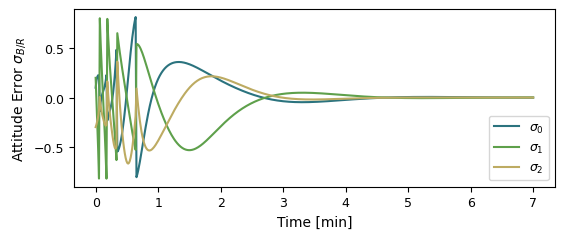

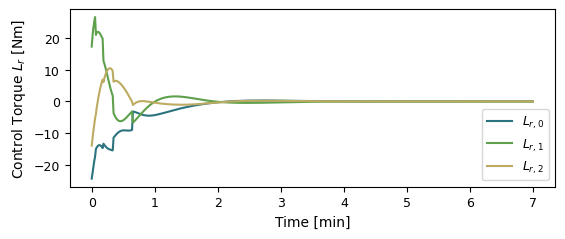

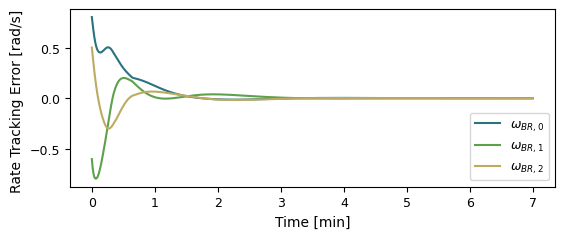

In [93]:
tumble = [[0.8], [-0.6], [0.5]]
desired_orientation = [0.0, 0.0, 0.0]

sim = Simulation(tumble, desired_orientation, num_log_points=500)
sim.run()
sim.plot()